# Satellite Image Processing for UAE Farms

Using sentinelhub instead of sentinelsat

## Part 1: Import dependencies

This is a trail account, and the instance ID will expire in 30 days!

In [1]:
INSTANCE_ID = '508b7647-1563-43ca-839e-320077f0f858'  # In case you put instance ID into configuration file you can leave this unchanged

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import datetime
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import misc

import pandas as pd

In [4]:
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox

In [5]:
import sys

# for converting to PDF
os.environ['PATH']

# add Inkspace
sys.path.append('C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\Scripts')


# for converting to PDF
os.environ['PATH']


'C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\lib\\site-packages\\shapely\\DLLs;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\DLLs;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\Library\\mingw-w64\\bin;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\Library\\usr\\bin;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\Library\\bin;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\Scripts;C:\\Users\\ZiAng\\Anaconda3\\envs\\satellite_env\\bin;C:\\Users\\ZiAng\\bin;C:\\Program Files\\Git\\mingw64\\bin;C:\\Program Files\\Git\\usr\\local\\bin;C:\\Program Files\\Git\\usr\\bin;C:\\Program Files\\Git\\usr\\bin;C:\\Program Files\\Git\\mingw64\\bin;C:\\Program Files\\Git\\usr\\bin;C:\\Users\\ZiAng\\bin;C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath;C:\\Program Files (x86)\\Intel\\iCLS Client;C:\\Program Files\\Intel\\iCLS Client;C:\\WINDOWS\\system32;C:\\WINDOWS;C:\\WINDOWS\\System32\\Wbem;C:\\WINDOWS\\System32\\WindowsP

## Part 2: subroutines to call

In [6]:
# To plot image, given one value, or RGB
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)
    plt.colorbar()


In [7]:
# To calc bounding box, given geojson
def bbox(coord_list):
    box = []
    for i in (0,1):
        res = sorted(coord_list, key=lambda x:x[i])
        box.append((res[0][i],res[-1][i]))
    ret = box[0][0], box[1][0], box[0][1], box[1][1]
    return ret

## Part 3: Create bbox for data request

In [8]:
hatta_farm_polygon =         [
            [
              54.9235725402832,
              24.682117183257752
            ],
            [
              55.03154754638672,
              24.682117183257752
            ],
            [
              55.03154754638672,
              24.761796517185815
            ],
            [
              54.9235725402832,
              24.761796517185815
            ],
            [
              54.9235725402832,
              24.682117183257752
            ]
          ]

# hatta_farm_polygon = [
# [
# -95.40244861131626,
# 29.726160910478676
# ],
# [
# -95.402158379915,
# 29.72616241818724
# ],
# [
# -95.40244861131626,
# 29.726500910478676
# ]
# ]

betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)


(54.9235725402832, 24.682117183257752, 55.03154754638672, 24.761796517185815)


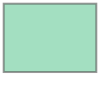

In [9]:
farm_bbox = bbox(hatta_farm_polygon)
print(farm_bbox)
farm_bbox = BBox(farm_bbox, crs=CRS.WGS84)
farm_bbox

## Part 4: Get Image
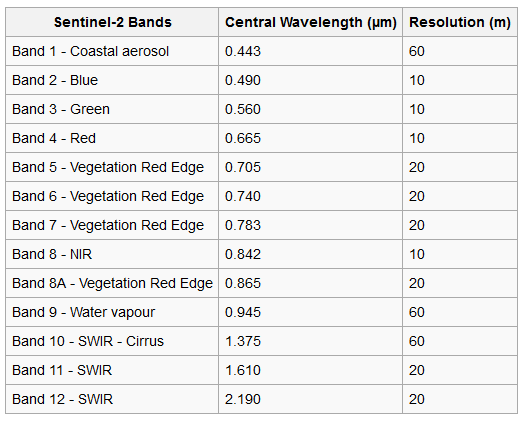
What we are downloading here is RGB + NIR, namely B04, B03, B02, B08. RGB is for visual and NIR for calculating NDVI

WCS request is better than WMS because it specifies resolution, not width

In [10]:
# wms_bands_request = WmsRequest(#layer='BANDS-S2-L1C',
#                                layer='RGB-PLUS-NIR',
#                                #bbox = betsiboka_bbox,
#                                bbox = farm_bbox,
#                                #time=('2017-12-01', '2017-12-31'),
#                                time='latest',
#                                maxcc=0.2,  # MUST HAVE!!! Low cloud coverage
#                                width=1920,
#                                image_format=MimeType.TIFF_d32f,
#                                instance_id=INSTANCE_ID)
# wms_bands_img = wms_bands_request.get_data()

wcs_bands_request = WcsRequest(#layer='BANDS-S2-L1C',
                               layer='RGB-PLUS-NIR',
                               #bbox = betsiboka_bbox,
                               bbox = farm_bbox,
                               #time=('2017-12-01', '2017-12-31'),
                               time='latest',
                               maxcc=0.2,  # MUST HAVE!!! Low cloud coverage
                               resx='10m', resy='10m',
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)
wcs_bands_img = wcs_bands_request.get_data()

In [11]:
#np.shape(wms_bands_img)
np.shape(wcs_bands_img)

(1, 886, 1091, 4)

In [12]:
np.array(wcs_bands_img)[0, 0, 0, :]

array([0.90275   , 0.734     , 0.64175   , 0.92437035], dtype=float32)

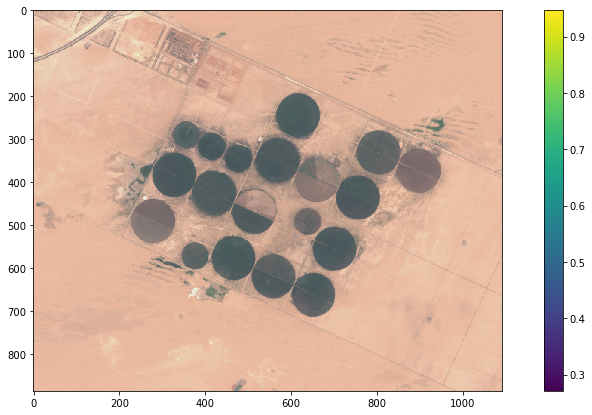

In [13]:
# Plot the RGB part of the image
plot_image(wcs_bands_img[-1][:, :, [0,1,2]], 1)

# Colorbar is for the monochronic images later, not relevant here.

## Part 4a: Comparing L1C with L2A

The Sentinel-2 mission is a land monitoring constellation of two satellites that provide high resolution optical imagery and provide continuity for the current SPOT and Landsat missions. The mission provides a global coverage of the Earth's land surface every 5 days, making the data of great use in on-going studies. L1C data are available from June 2015 globally. L2A data are available from April 2017 over wider Europe region and globally since December 2018.

Basically L2A has some post processing and looks clearer than L1C.

In [42]:
wcs_bands_request = WcsRequest(#layer='BANDS-S2-L1C',
                               layer='RGB-PLUS-NIR-L2A',
                               #bbox = betsiboka_bbox,
                               bbox = farm_bbox,
                               #time=('2017-12-01', '2017-12-31'),
                               time='latest',
                               maxcc=0.2,  # MUST HAVE!!! Low cloud coverage
                               resx='10m', resy='10m',
                               image_format=MimeType.TIFF_d32f,
                               instance_id=INSTANCE_ID)
wcs_bands_img = wcs_bands_request.get_data()

In [43]:
#np.shape(wms_bands_img)
np.shape(wcs_bands_img)

(1, 886, 1091, 4)

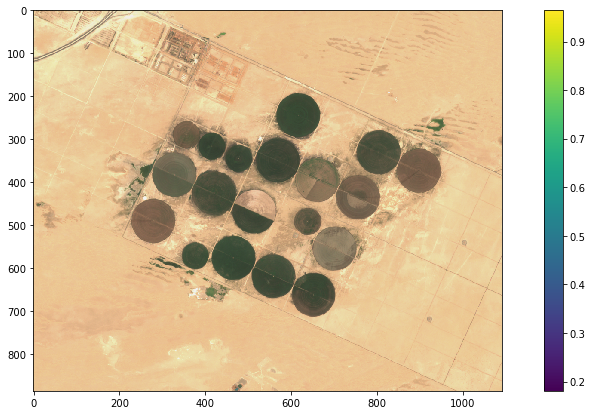

In [44]:
# Plot the RGB part of the image
plot_image(wcs_bands_img[-1][:, :, [0,1,2]], 1)

# Colorbar is for the monochronic images later, not relevant here.

## Part 5: Create NDVI

To calculate the NDVI, you need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:

(nir - red)/(nir + red)

In [45]:
nir = np.array(wcs_bands_img[-1][:, :, 3])
red = np.array(wcs_bands_img[-1][:, :, 0])
green = np.array(wcs_bands_img[-1][:, :, 1])
blue = np.array(wcs_bands_img[-1][:, :, 2])

ndvi = (nir-red)/(nir+red)

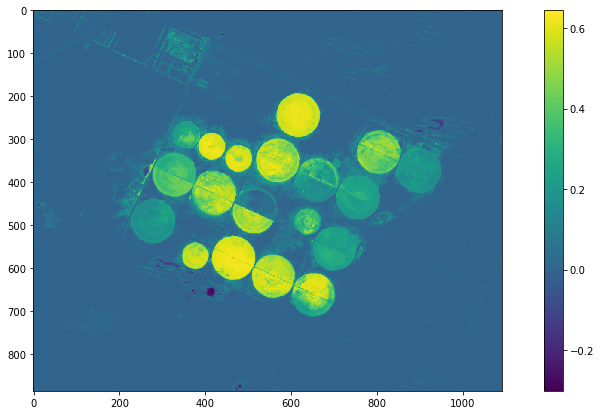

In [46]:
plot_image(ndvi, 1)

(array([1.42000e+02, 1.18000e+02, 1.49000e+02, 3.77000e+02, 7.15000e+02,
        5.92000e+02, 7.39113e+05, 5.35640e+04, 2.48230e+04, 1.97990e+04,
        2.11930e+04, 1.77940e+04, 8.65200e+03, 7.37800e+03, 7.37900e+03,
        9.36800e+03, 9.47200e+03, 1.26120e+04, 1.94340e+04, 1.39520e+04]),
 array([-0.30041152, -0.25318876, -0.20596597, -0.1587432 , -0.11152042,
        -0.06429765, -0.01707487,  0.0301479 ,  0.07737068,  0.12459345,
         0.17181623,  0.21903901,  0.2662618 ,  0.31348455,  0.36070734,
         0.4079301 ,  0.45515287,  0.50237566,  0.54959846,  0.5968212 ,
         0.644044  ], dtype=float32),
 <a list of 20 Patch objects>)

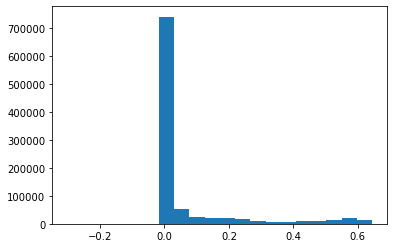

In [47]:
# Blue is close to 0, which is desert; Purple is minus, which is the small ponds of water nearby;
# And green-yellow is positive, the hotter the image the healthier the vegetation

# Histogram of NDVI
plt.hist(np.array(ndvi).flatten(), bins = 20)

## Part 6: Create Chlorophyll
Chlorophyll = 0.76|R–B|–0.12|R-G|+0.64|G–B|

If I can spell it I can do it

In [17]:
chlo = 0.76 * np.abs(red-blue) - 0.12 * np.abs(red-green) + 0.64 * np.abs(green-blue)

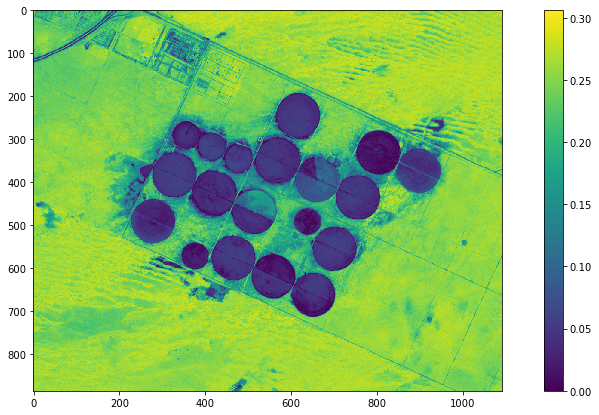

In [18]:
plot_image(chlo, 1)

(array([1.41570e+04, 2.23170e+04, 4.19250e+04, 4.40270e+04, 9.03000e+03,
        7.05500e+03, 6.57000e+03, 6.72700e+03, 8.44600e+03, 1.10020e+04,
        1.44540e+04, 1.78470e+04, 2.19710e+04, 2.92370e+04, 5.27720e+04,
        1.26084e+05, 2.64210e+05, 2.29966e+05, 3.87510e+04, 7.80000e+01]),
 array([0.        , 0.01530356, 0.03060711, 0.04591067, 0.06121423,
        0.07651778, 0.09182134, 0.10712489, 0.12242845, 0.13773201,
        0.15303557, 0.16833912, 0.18364269, 0.19894624, 0.21424979,
        0.22955334, 0.24485691, 0.26016048, 0.27546403, 0.29076758,
        0.30607113], dtype=float32),
 <a list of 20 Patch objects>)

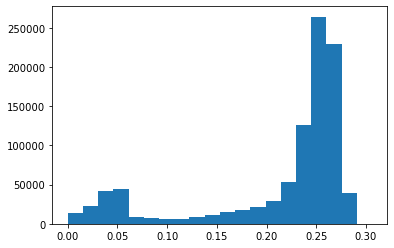

In [19]:
# The farms have zero chlorophyll??
# I don't know why it's reversed maybe something wrong with the formula

# Histogram of Chlorophyll
plt.hist(np.array(chlo).flatten(), bins = 20)

## Part 7: Machine Learning
We will start with EuroSat (the German model) first because we already have it. Otherwise we would have to go through the pain of getting traning data and training the model.

In [39]:
 # Load the model
from keras.models import load_model
image_model = load_model("deep_learning_eurosat.hdf5")

In [49]:
# Apply image cutter
from cropper64a import image_cropper as crp

img_array = np.array(wcs_bands_img[0][:, :, 0:3])
cut_array = crp(img_array)[0]

np.shape(cut_array)

Original image has a shape of: (886, 1091, 3).
------------------------------------------------------------------------------------------
Resized image has a shape of: (832, 1088, 3).
------------------------------------------------------------------------------------------
Number of resized 64 x 64 images: 221.
------------------------------------------------------------------------------------------


(221, 64, 64, 3)

C:\Users\ZiAng\Anaconda3\envs\satellite_env\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


[77.  3.  0.  0.  0.  0. 51.  0.  3. 83.]


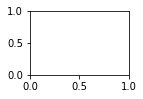

In [50]:
# Define an aggregate for y to accumulate categories
agg_y = [0,0,0,0,0,0,0,0,0,0]
# Apply model to learn
for block in cut_array[:]:
    #print(np.shape(block))
    plt.subplot(339)
    x = block.reshape((-1, 64, 64, 3))

    y = image_model.predict(x).round()
    #print(y)
    agg_y += y[0]
print(agg_y)

In [ ]:
# Looks like the model works slightly better for L1C, not L2A data
\

## Part 8: Interpretation
Categories:

 'AnnualCrop': 0,
 
 'Forest': 1,
 
 'HerbaceousVegetation': 2,
 
 'Highway': 3,
 
 'Industrial': 4,
 
 'Pasture': 5,
 
 'PermanentCrop': 6,
 
 'Residential': 7,
 
 'River': 8,
 
 'SeaLake': 9

In [ ]:
# The model classified 161 blocks as crops, and 38 blocks as sea lake

# Apparently, what's acrually desert was classified as crop,

# and what's actually crop was classified as sea/lake.

# Two lessons learned here:

# 1) A model that works for Europe may not work for the UAE

# 2) Better have NIR included in the model (EuroSat is RGB only), to enhance classification accuracy for crop/vegetation